In [60]:
from datetime import datetime
from typing import Optional

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy import select, BinaryExpression, func

from src.const import BASE_DATA_PATH
from src.db.db_mgmt import DatabaseConfig, DatabaseManager
from src.db.db_models import DBPost, Base

conf = DatabaseConfig("sqlite", (BASE_DATA_PATH / "twitter.sqlite").as_posix(), Base)
db = DatabaseManager(conf)


# todo use misc.helper
def get_posts(platform: str,
              task_name: Optional[str] = None,
              task_step: Optional[int] = None,
              conditions: Optional[BinaryExpression | list[BinaryExpression]] = None
              ) -> list[DBPost]:
    with db.get_session() as session:
        # Start with a base query
        query = select(
            func.date(DBPost.date_created).label('day'),
            func.count().label('count')
        ).group_by(
            func.date(DBPost.date_created)
        )

        # Platform is required
        query = query.where(DBPost.platform == platform)

        if conditions is not None:
            if isinstance(conditions, list):
                for condition in conditions:
                    query = query.where(condition)
            else:
                query = query.where(conditions)

        # Execute the query and return the results
        result = session.execute(query)
        return result.all()


In [63]:
def get_year_counts(year: int) -> pd.Series:
    results = get_posts("youtube",
                        conditions=DBPost.date_created.between(
                            datetime(year, 1, 1),
                            datetime(year + 1, 1, 1)
                        ))

    # Convert to pandas Series with days as index
    counts = pd.Series({row[0]: row[1] for row in results})
    return counts

#get_year_counts(2022)

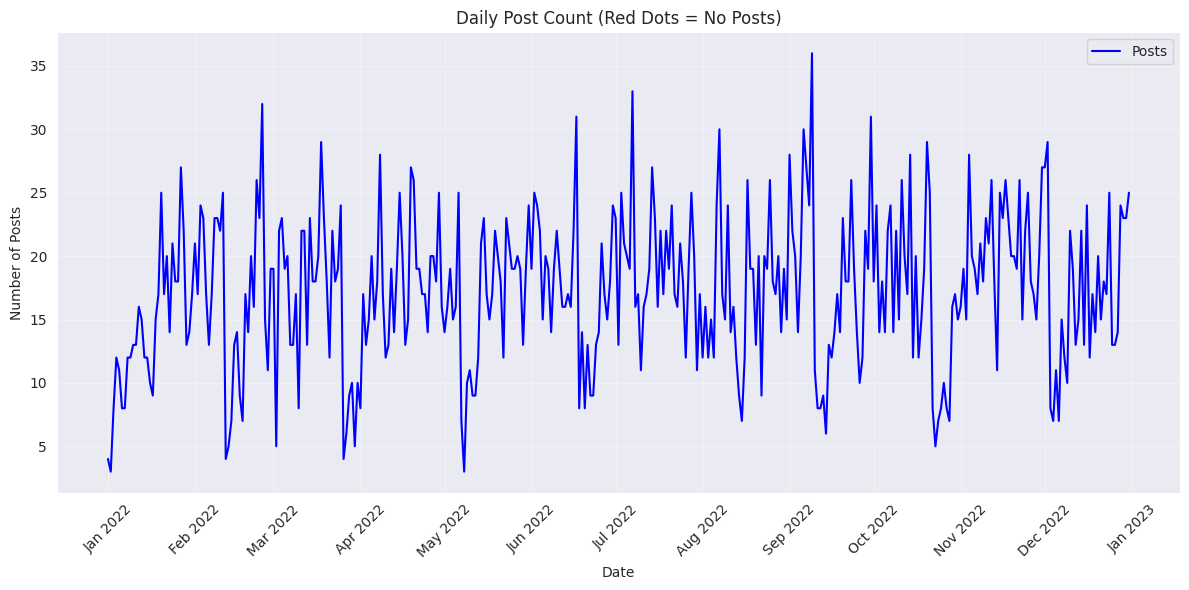

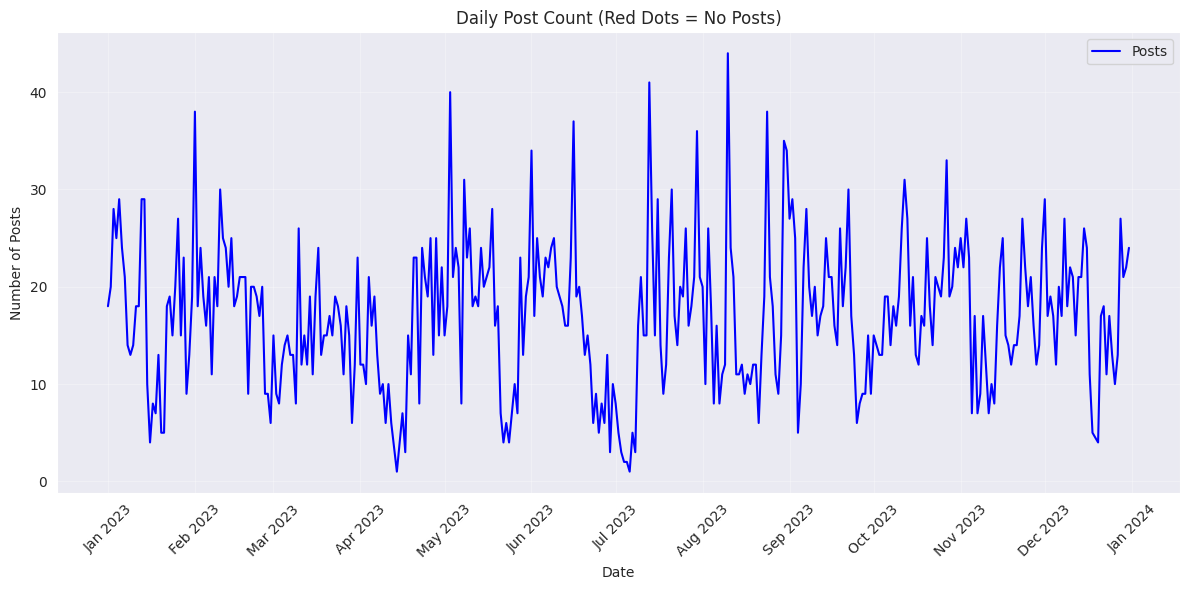

In [67]:
import matplotlib.dates as mdates
def plot_daily_items(daily_counts: pd.Series):
   plt.figure(figsize=(12, 6))


   # Convert index to datetime if not already
   if not isinstance(daily_counts.index, pd.DatetimeIndex):
       daily_counts.index = pd.to_datetime(daily_counts.index)

   sns.lineplot(data=daily_counts, color='blue', label='Posts')

   # Zero days highlight
   zero_days = daily_counts[daily_counts == 0]
   if not zero_days.empty:
       plt.scatter(zero_days.index, zero_days.values,
                  color='red', s=10, label='No Posts',
                  zorder=5)

   plt.title('Daily Post Count (Red Dots = No Posts)')
   plt.xlabel('Date')
   plt.ylabel('Number of Posts')

   # Improved x-axis labels
   plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
   plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
   plt.xticks(rotation=45)

   plt.grid(True, alpha=0.3)
   plt.legend()
   plt.tight_layout()
   return plt

plot = plot_daily_items(get_year_counts(2022))
plot.show()
plot = plot_daily_items(get_year_counts(2023))
plot.show()